### EXP: Pilote3 QC rating 

- **Aim:** Assessing quality control (QC) of brain registration with experts on the Zooniverse platform. Raters are neuroimmaging students gathered on a brainhack event ( ref: https://www.zooniverse.org/projects/simexp/brain-match ).

- **Exp:** 
    - We choose 50 anatomical brain images (?? OK, ?? Maybe and ?? Fail)   preprocced with NIAK pipelines from ADHD200 datsets.
    - We asked raters on the Zooniverse platform to QC images based on the instruction from the tutorial.

In [1]:
import os
import pandas as pd
import numpy as np
import json
import itertools
import seaborn as sns
from sklearn import metrics
from matplotlib import gridspec as gs
import matplotlib.pyplot as plt
from functools import reduce

In [2]:
%matplotlib inline
%load_ext rpy2.ipython
sns.set(style="white")

In [3]:
def CustomParser(data):
    j1 = json.loads(data)
    return j1

In [218]:
# Read raw table
classifications = pd.read_csv('../data/rating/brain-match-classifications-12-10-2018.csv', 
                              converters={'metadata':CustomParser,
                                          'annotations':CustomParser,
                                          'subject_data':CustomParser},
                              header=0)

In [219]:
classifications.workflow_name.unique()

array(['Spot anatomical differences', 'Spot functional differences',
       'anat_internal_rating_pierre', 'anat_internal_rating_yassine',
       'Training Session', 'Basile', 'Benjamin', 'Maxime', 'Angela',
       'Sara', 'Pierre_func_rate_1', 'Pierre_anat_rate1',
       'Yassine_func_rate_1', 'Pierre_func_rate_2', 'Start Project',
       'Start Project 1', 'Expert Project 1', 'Expert Project 2',
       'Start Project 2'], dtype=object)

In [220]:
# Filter out only specific workflow
ratings = classifications.loc[classifications['workflow_name'].isin(['Basile','Benjamin', 'Maxime', 'Angela', 
                                                                     'Sara'])]
ratings.count()

classification_id    264
user_name            264
user_id              264
user_ip              264
workflow_id          264
workflow_name        264
workflow_version     264
created_at           264
gold_standard          0
expert                 0
metadata             264
annotations          264
subject_data         264
subject_ids          264
dtype: int64

In [221]:
# extract tagging count
ratings.loc[:,"n_tagging"] = [ len(q[1]['value']) for q in ratings.annotations]
# extract rating count
ratings.loc[:,"rating"] = [ q[1]['value'] for q in ratings.annotations]
# extract subjects id
ratings.loc[:,"ID"] = [ row.subject_data[str(ratings.subject_ids.loc[ind])]['subject_ID'] for ind,row in ratings.iterrows()]
# extract files name
ratings.loc[:,"imgnm"] = [ row.subject_data[str(ratings.subject_ids.loc[ind])]['Image1'] for ind,row in ratings.iterrows()]

/mnt/home_sq/yassinebha/.virtualenvs/zooniverse_qc/lib/python3.5/site-packages/pandas/core/indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/mnt/home_sq/yassinebha/.virtualenvs/zooniverse_qc/lib/python3.5/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [222]:
# How many rating per user
user_count = ratings.user_name.value_counts()
user_count

bpinsard            56
hereinlies          56
benjamindeleener    52
saradupont          50
angelatam           50
Name: user_name, dtype: int64

In [223]:
#select only users that have rated a certain ammount of images 
list_user = user_count.index
list_user = list_user[user_count.values>=10]
user_count[list_user]

bpinsard            56
hereinlies          56
benjamindeleener    52
saradupont          50
angelatam           50
Name: user_name, dtype: int64

In [224]:
# remove users with less rating then the selected threshold
ratings = ratings[ratings.user_name.isin(list_user)]
ratings.count()

classification_id    264
user_name            264
user_id              264
user_ip              264
workflow_id          264
workflow_name        264
workflow_version     264
created_at           264
gold_standard          0
expert                 0
metadata             264
annotations          264
subject_data         264
subject_ids          264
n_tagging            264
rating               264
ID                   264
imgnm                264
dtype: int64

In [225]:
# drop duplicated rating
inc = 0
sum_dup = 0
for ind,user in enumerate(ratings.user_name.unique()):
    user_select_df = ratings[ratings.user_name.isin([user])]
    mask=~user_select_df.ID.duplicated()
    dup = len([m for m in mask if m == False])
    sum_dup = sum_dup+ dup
    if dup > 0 :
        print('{} have {} duplicated ratings'.format(user,dup))
    if ind == 0 and inc == 0:
        classi_unique= user_select_df[mask]
        inc+=1
    else:
        classi_unique = classi_unique.append(user_select_df[~user_select_df.ID.duplicated()])
        inc+=1
print('Total number of duplicated ratings  = {}'.format(sum_dup))

bpinsard have 6 duplicated ratings
benjamindeleener have 2 duplicated ratings
hereinlies have 6 duplicated ratings
Total number of duplicated ratings  = 14


In [226]:
# Get the final rating numbers per subject
user_count = classi_unique.user_name.value_counts()
user_count

bpinsard            50
saradupont          50
angelatam           50
hereinlies          50
benjamindeleener    50
Name: user_name, dtype: int64

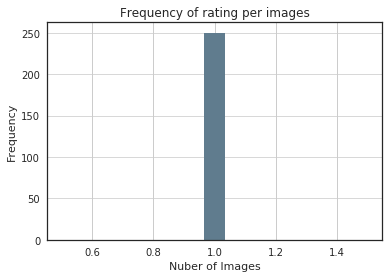

In [227]:
# plot rating per image distribution
image_count = classi_unique.subject_ids.value_counts()
image_count.plot.hist(grid=True,rwidth=0.9, bins=13,color='#607c8e')
plt.title('Frequency of rating per images')
plt.xlabel('Nuber of Images')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)

In [228]:
#Create Users rating dataframe
list_user = user_count.index
concat_rating = [classi_unique[classi_unique.user_name == user][['ID','rating']].rename(columns={'rating': user})
                  for user in list_user]

df_ratings = reduce(lambda left,right: pd.merge(left,right,how='outer',on='ID'), concat_rating).apply(lambda x: x.str.strip() if x.dtype == "object" else x)
df_ratings.head()

,ID,bpinsard,saradupont,angelatam,hereinlies,benjamindeleener
0,X3912996,Fail,Maybe,Maybe,Fail,OK
1,X2768273,Fail,Fail,Fail,Fail,Fail
2,X1743472,Fail,Fail,Fail,Fail,Fail
3,X3160561,Fail,Maybe,Maybe,Maybe,Fail
4,X2409220,Fail,Fail,Fail,Fail,Maybe


In [229]:
# remove duplicates
df_ratings = df_ratings[~df_ratings.ID.duplicated()]

### Explore the concensus of rating between images

In [395]:
# Get ratings from images rated more tan N different rates 
n = 0 # Minimun number of ratings per image
stuff = np.array([[row.ID,
                   np.sum(row[1:].values=='Fail'),
                   np.sum(row[1:].values=='Maybe'),
                   np.sum(row[1:].values=='OK')]  
                  for ind, row in df_ratings.iterrows() if np.sum([np.sum(row[1:-1].values=='Fail'),
                                                                 np.sum(row[1:-1].values=='Maybe'),
                                                                 np.sum(row[1:-1].values=='OK')]) >= n])
df_score = pd.DataFrame(data=stuff, columns=['ID','Fail', 'Maybe', 'OK'])
df_score.head()

,ID,Fail,Maybe,OK
0,X3912996,2,2,1
1,X2768273,5,0,0
2,X1743472,5,0,0
3,X3160561,2,3,0
4,X2409220,4,1,0


In [396]:
# Normalise table's row
df_score_tmp = df_score[['Fail','Maybe','OK']].astype('int')
nb_rating = df_score[['Fail','Maybe','OK']].astype('int').sum(axis="columns")
df_norm = pd.DataFrame( index=df_score.index,columns=['ID','Fail', 'Maybe', 'OK'])
for status in ['Fail','Maybe','OK']:
    for image in df_score.index:
        df_norm[status][image] = np.int(df_score[status][image])/nb_rating[image]
        df_norm['ID'][image] = df_score['ID'][image]
# get max value
max_value = [row.iloc[1:].get_values().max() for ind,row in df_norm.iterrows()]
df_norm.loc[:,'max_value_NoExp'] = max_value
# get concensus rating
s = ['Fail', 'Maybe', 'OK']
#max_rate = [row.iloc[1:].idxmax(axis=1) for ind,row in df_norm.iterrows()]
max_rate = [s[row[1:].values.argmax()] for rid, row in df_norm.iterrows()]
df_norm.loc[:,'concensus_NoExp'] = max_rate
df_norm.head()

,ID,Fail,Maybe,OK,max_value_NoExp,concensus_NoExp
0,X3912996,0.4,0.4,0.2,0.4,Fail
1,X2768273,1,0,0,1.0,Fail
2,X1743472,1,0,0,1.0,Fail
3,X3160561,0.4,0.6,0,0.6,Maybe
4,X2409220,0.8,0.2,0,0.8,Fail


Text(0, 0.5, 'Concensus rating')

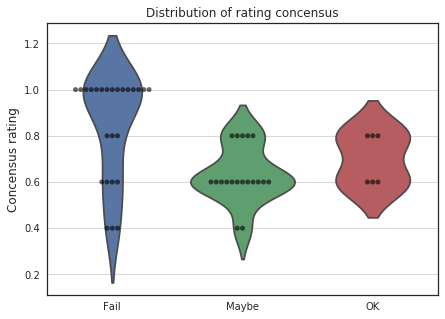

In [397]:
#Setting the figure with matplotlib
plt.figure(figsize=(7,5))
#plt.xticks(rotation=90)
plt.rcParams["axes.labelsize"] = 12
 
#Creating the desired plot
sns.violinplot(x='concensus_NoExp',y='max_value_NoExp',data=df_norm,
              inner=None #removes the inner bars inside the violins 
              )
 
sns.swarmplot(x='concensus_NoExp',y='max_value_NoExp',data=df_norm,
             color='k',#for making the points black
             alpha=0.6) #value of alpha will increase the transparency
 
#Title for the plot
plt.grid(axis='y', alpha=0.75)
plt.title('Distribution of rating concensus')
plt.xlabel('')
plt.ylabel('Concensus rating')

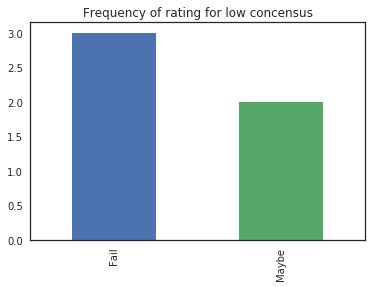

In [398]:
count_ = df_norm.concensus_NoExp[[0 <= row.max_value_NoExp < 0.56   for ind, row in df_norm.iterrows() ]].value_counts()
axes = count_.plot.bar(title = 'Frequency of rating for low concensus')

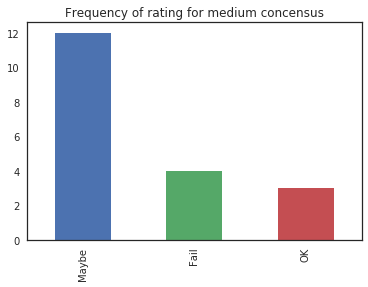

In [399]:
count_ = df_norm.concensus_NoExp[[0.5 <= row.max_value_NoExp < 0.65   for ind, row in df_norm.iterrows() ]].value_counts()
axes = count_.plot.bar(title = 'Frequency of rating for medium concensus')

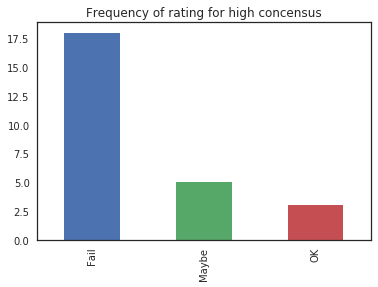

In [400]:
count_ = df_norm.concensus_NoExp[[0.65 <= row.max_value_NoExp <= 1   for ind, row in df_norm.iterrows() ]].value_counts()
axes = count_.plot.bar(title = 'Frequency of rating for high concensus')

### Merge extra Pilot3 rating and get Kappa score

In [401]:
pilot3 = pd.read_csv('../data/rating/Pilot3_internal_rating-PB_YB.csv')[['ID','YB','PB_1']]
pilot3.head()

,ID,YB,PB_1
0,SZ0040029,OK,Maybe
1,SZ0040039,OK,OK
2,SZ0040042,OK,OK
3,SZ0040044,OK,OK
4,SZ0040046,OK,OK


In [402]:
# Merge 
dfs = [pilot3.rename(columns={'YB':'Yben','PB_1':'Pbel'}),
       df_ratings.rename(columns={'concensus_NoExp':'Cons_P3'}),
       df_norm[['ID','concensus_NoExp']].rename(columns={'concensus_NoExp':'Cons_P3'})]
merge_ratings = reduce(lambda left,right: pd.merge(left,right,on='ID'), dfs)

In [403]:
merge_ratings.head()

,ID,Yben,Pbel,bpinsard,saradupont,angelatam,hereinlies,benjamindeleener,Cons_P3
0,SZ0040029,OK,Maybe,OK,Maybe,OK,Fail,Maybe,Maybe
1,SZ0040039,OK,OK,Fail,OK,Maybe,OK,OK,OK
2,SZ0040042,OK,OK,Maybe,Maybe,OK,Fail,OK,Maybe
3,SZ0040044,OK,OK,Fail,OK,OK,Maybe,OK,OK
4,SZ0040046,OK,OK,Maybe,Maybe,OK,Maybe,OK,Maybe


In [404]:
# Save a copy Pilot3 ratings
merge_ratings.to_csv('../data/rating/Pilot3_internal_rating.csv',index=False)

In [405]:
# Replace OK with 1 , Maybe with 2 and Fail with 3
merge_ratings.replace({'OK':1,'Maybe':2, 'Fail':3}, inplace=True)
merge_ratings.rename(columns={'bpinsard':'Bpin',
                              'saradupont':'Sdup',
                              'angelatam':'Atam',
                              'hereinlies':'Mpel',
                              'benjamindeleener':'Bdel'},inplace=True)
merge_ratings = merge_ratings[['ID','Yben','Pbel','Atam','Bdel','Sdup','Mpel','Bpin']]
merge_ratings.head()

,ID,Yben,Pbel,Atam,Bdel,Sdup,Mpel,Bpin
0,SZ0040029,1,2,1,2,2,3,1
1,SZ0040039,1,1,2,1,1,1,3
2,SZ0040042,1,1,1,1,2,3,2
3,SZ0040044,1,1,1,1,1,2,3
4,SZ0040046,1,1,1,1,2,2,2


In [252]:
%%R
suppressPackageStartupMessages(library(dplyr))
#install.packages("irr") 
library(irr)

In [253]:
# Percenteage of agrrement between raters with R package IRR
agree_ = merge_ratings.drop(columns='ID')
%Rpush agree_
agree_n = %R agree(agree_)
print(agree_n)

 Percentage agreement (Tolerance=0)

 Subjects = 50 
   Raters = 7 
  %-agree = 28 



In [412]:
def kappa_score(k_df ):
    '''compute Kappa between diferent raters organized in dataframe'''
    k_store = np.zeros((len(k_df.columns), len(k_df.columns)))
    p_store = np.zeros((len(k_df.columns), len(k_df.columns)))
    %Rpush k_df
    for user1_id, user1 in enumerate(k_df.columns):
        for user2_id, user2 in enumerate(k_df.columns):
            weight = np.unique(kappa_df[[user1,user2]])
            %Rpush user1_id user1 user2_id user2 weight
            kappaR =  %R kappa2(k_df[,c(user1,user2)],weight)
            #kappa = metrics.cohen_kappa_score(list(k_df[user1]),list(k_df[user2]))
            # store the kappa
            k_store[user1_id, user2_id] = [kappaR[x][0] for x in range(np.shape(kappaR)[0])][4]
            p_store[user1_id, user2_id] = [kappaR[x][0] for x in range(np.shape(kappaR)[0])][-1]
    return k_store, p_store

In [413]:
# Get Kappa score out of all different combination of ratings
kappa_df  = merge_ratings.drop(columns='ID')
kappa_store, Pval_store = kappa_score(kappa_df)
mean_kap = np.mean(kappa_store[np.triu_indices(len(kappa_store),k=1)])
std_kap = np.std(kappa_store[np.triu_indices(len(kappa_store),k=1)])
print('Mean Kappa : {0:.2f} , std : {1:.2f}\n'.format(mean_kap, std_kap))

#calculte the over all kappa values of all ratings
%Rpush kappa_df
fleiss_kappa = %R kappam.fleiss(kappa_df,c(0,1,2))
print(fleiss_kappa)

Mean Kappa : 0.49 , std : 0.20

 Fleiss' Kappa for m Raters

 Subjects = 50 
   Raters = 7 
    Kappa = 0.406 

        z = 18.3 
  p-value = 0 



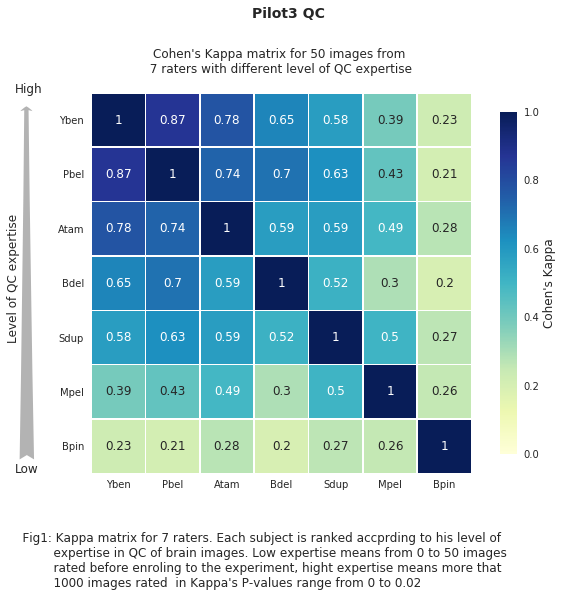

In [414]:
# Plot kappa matrix
kappa_out = pd.DataFrame(kappa_store, 
                         index=kappa_df.columns.get_values(),
                         columns=kappa_df.columns.get_values())


# Set up the matplotlib figure
f, axes = plt.subplots(figsize = (10,7))
f.subplots_adjust(hspace= .8)

f.suptitle('Pilot3 QC',x=0.49,y=1.05, fontsize=14, fontweight='bold')
# Draw kappa heat map
sns.heatmap(kappa_out,vmin=0,vmax=1,cmap="YlGnBu",
            square=True,
            annot=True,
            linewidths=.5, 
            cbar_kws={"shrink": .9,"label": "Cohen's Kappa"}, 
            ax=axes)
axes.set_yticks([x+0.5 for x in range(len(kappa_df.columns))])
axes.set_yticklabels(kappa_df.columns,rotation=0)
axes.set_title("Cohen's Kappa matrix for {} images from \n  7 raters with different level of QC expertise  ".format(len(merge_ratings)),
               pad=20,fontsize=12)
axes.annotate('Low', xy=(-0.17, 0.97),xytext=(-0.2, -0), xycoords='axes fraction',
              arrowprops=dict(arrowstyle="fancy,tail_width=1.2,head_width=01",
                            fc="0.7", ec="none",
                            linewidth =2))

# Caption
pval = np.unique(Pval_store)[-1]
txt = '''
    Fig1: Kappa matrix for 7 raters. Each subject is ranked accprding to his level of 
            expertise in QC of brain images. Low expertise means from 0 to 50 images 
            rated before enroling to the experiment, hight expertise means more that 
            1000 images rated  in Kappa's P-values range from {:.2g} to {:.2g} '''.format(Pval_store.min(), Pval_store.max())
f.text(0.1,-0.1,txt,fontsize=12)
f.text(0.11,0.88,'High',fontsize=12)
f.text(0.10,0.62,'Level of QC expertise',fontsize=12,rotation=90)
# Save figure
f.savefig('../reports/figures/Pilot3_qc.svg')

In [415]:
from IPython.display import Image
Image(url= "https://i.stack.imgur.com/kYNd6.png" ,width=600, height=600)

### Report tagging from Beta1 raters

In [416]:
# output markings from classifications
clist=[]
for index, c in classi_unique.iterrows():
    if c['n_tagging'] > 0:
        for q in c.annotations[0]['value']:
            clist.append({'ID':c.ID, 'workflow_name':c.workflow_name,'user_name':c.user_name, 'rating':c.rating,'imgnm':c.imgnm, 
                          'x':q['x'], 'y':np.round(q['y']).astype(int), 'r':'1.5','n_tagging':c.n_tagging ,'frame':q['frame']})
    else:
        clist.append({'ID':c.ID, 'workflow_name':c.workflow_name, 'user_name':c.user_name,'rating':c.rating,'imgnm':c.imgnm, 
                          'x':float('nan'), 'y':float('nan'), 'r':float('nan'),'n_tagging':c.n_tagging ,'frame':'1'})

col_order=['ID','workflow_name','user_name','rating','x','y','r','n_tagging','imgnm','frame']
out_tag = pd.DataFrame(clist)[col_order]
out_tag.user_name.replace({'simexp':'PB','Yassinebha':'YB'},inplace=True)
out_tag.head()

,ID,workflow_name,user_name,rating,x,y,r,n_tagging,imgnm,frame
0,X3912996,Basile,bpinsard,Fail,56.0,364,1.5,4,X_3912996_anat.jpg,1
1,X3912996,Basile,bpinsard,Fail,87.0,312,1.5,4,X_3912996_anat.jpg,0
2,X3912996,Basile,bpinsard,Fail,371.0,310,1.5,4,X_3912996_anat.jpg,0
3,X3912996,Basile,bpinsard,Fail,293.0,314,1.5,4,X_3912996_anat.jpg,1
4,X3912996,Basile,bpinsard,Fail,333.0,598,1.5,4,X_3912996_anat.jpg,0


In [417]:
# Extract unique IDs for each image
ids_imgnm = np.reshape([out_tag.ID.unique(),out_tag.imgnm.unique()],(2,np.shape(out_tag.ID.unique())[0]))
df_ids_imgnm = pd.DataFrame(np.sort(ids_imgnm.T, axis=0),columns=['ID', 'imgnm'])
df_ids_imgnm.head()

,ID,imgnm
0,SZ0040005,SZ0040005_anat.jpg
1,SZ0040007,SZ0040007_anat.jpg
2,SZ0040011,SZ0040011_anat.jpg
3,SZ0040016,SZ0040016_anat.jpg
4,SZ0040021,SZ0040021_anat.jpg


In [418]:
# Create custom color map
from matplotlib.colors import LinearSegmentedColormap , ListedColormap
from PIL import Image
def _cmap_from_image_path(img_path):
        img = Image.open(img_path)
        img = img.resize((256, img.height))
        colours = (img.getpixel((x, 0)) for x in range(256))
        colours = [(r/255, g/255, b/255, a/255) for (r, g, b, a) in colours]
        return colours,LinearSegmentedColormap.from_list('from_image', colours)


coll,a=_cmap_from_image_path('../data/Misc/custom_ColBar.png')
#invert color map
coll_r = ListedColormap(coll[::-1])

In [419]:
# set color different for each rater
list_tagger = out_tag.user_name.unique()
colors_tagger = sns.color_palette("Set2", len(list_tagger))

### Plot heat map for all tagging

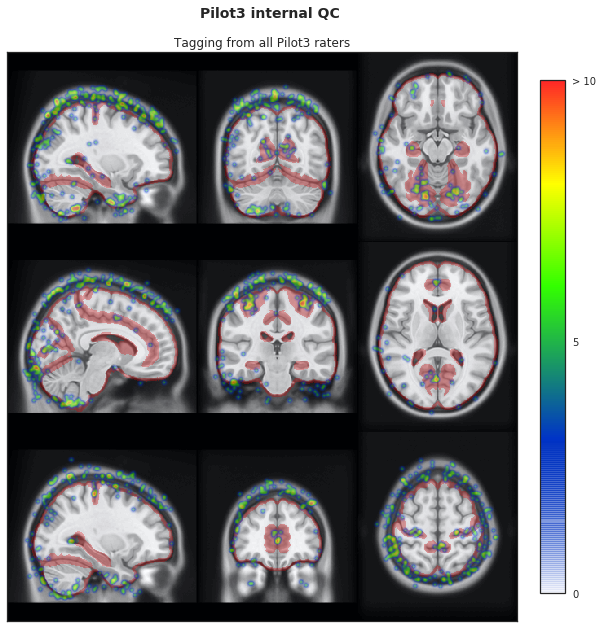

In [420]:
from heatmappy import Heatmapper
from PIL import Image

patches=list()
for ind, row in df_ids_imgnm.iterrows():
    out_tmp = out_tag[out_tag['ID'] == row.ID]
    patches.append([(row.x,row.y) for ind,row in out_tmp.iterrows()])

patches = [x for x in sum(patches,[]) if str(x[0]) != 'nan']

# plot heat map on the template
f, axes = plt.subplots(1, 1,figsize = (10,14))
f.subplots_adjust(hspace= .8)
f.suptitle('Pilot3 internal QC',x=0.49,y=.83, fontsize=14, fontweight='bold')

img = Image.open('../data/Misc/template_stereotaxic_v2.png')
axes.set_title('Tagging from all Pilot3 raters')

heatmapper = Heatmapper(opacity=0.5,
                        point_diameter=10,
                        point_strength = 0.5,
                        colours=a)
heatmap= heatmapper.heatmap_on_img(patches, img)

im = axes.imshow(heatmap,cmap=coll_r)
axes.set_yticklabels([])
axes.set_xticklabels([])

cbar = plt.colorbar(im, orientation='vertical', ticks=[0, 125, 255],fraction=0.046, pad=0.04,ax=axes)
cbar.ax.set_yticklabels(['0', '5', '> 10'])

img.close()
heatmap.close()
f.savefig('../reports/figures/Pilot3_qc_heatmap_tags.svg')